# House Prices: Advanced Regression Techniques

There is a huge difference between this project and the Titanic one I did previously. First of all, there are 79 features in this dataset, so it may take more work to extract relevant features to the saleprices. Second, compared to this project, Titanic survival prediction has a more straightforward process. 

### References
* [Stacked Regression to predict House Prices](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
* [房价预测kaggle入门项目](https://www.kaggle.com/marsggbo/kaggle)
* [Journey to the top 10%](https://www.kaggle.com/fiorenza2/journey-to-the-top-10)

## Import Modules

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.6) # setting seaborn default for plots

from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## Collect Training and Testing Datasets

In [161]:
train = pd.read_csv('Input/train.csv')
test = pd.read_csv('Input/test.csv')

Store the `Id` columns into new lists.

In [162]:
train_id = train['Id']
test_id = test['Id']

# Now drop Id from the train and test datasets
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

### Explore Train Data

Print the first five rows of train data.

In [163]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Besides Id and SalePrice columns, there are 79 features in these datasets.

### Column Information
* **MSSubClass**: The building class
* **MSZoning**: The general zoning classification
* **LotFrontage**: Linear feet of street connected to property
* **LotArea**: Lot size in square feet
* **Street**: Type of road access
* **Alley**: Type of alley access
* **LotShape**: General shape of property
* **LandContour**: Flatness of the property
* **Utilities**: Type of utilities available

...

...

...

... and so on, here I am not listing all descriptions of all 79 columns ;-)

**Total rows and columns of train data**

There are 1460 rows and 81 columns in train data.

In [164]:
train.shape

(1460, 80)

### Explore Test Data

Print the first 5 rows of test data.

In [165]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


**Total rows and columns of test data**

There are 1459 rows and 80 columns in test data.

In [166]:
test.shape

(1459, 79)

## Data Processing

### Analyze SalePrice

In [167]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [168]:
train['SalePrice'].isnull().sum()

0

There is no NULL or non-numerical value in this target variable. 

**Next, I am going to show distplot of SalePrice.**

Normal Distribution: mu = 180921.20 	 sigma = 79415.29



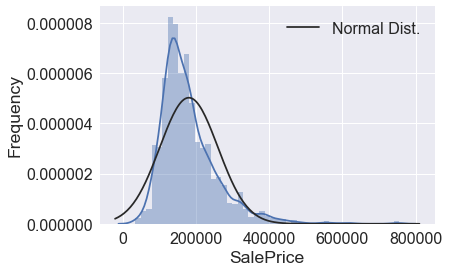

In [169]:
sns.distplot(train['SalePrice'], fit=norm)

# Get the fitted parameter used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print('Normal Distribution: mu = {:.2f} \t sigma = {:.2f}\n'.format(mu, sigma))

# Plot the normal distribution
plt.legend(['Normal Dist.'], loc='best')
plt.ylabel('Frequency')
plt.show()

**As we can see from the plot above, SalePrice is not normally distributed.** Let's see **kurtosis** and **skewness** of SalePrice.

In [170]:
# Kurtosis and Skewness
print("Kurtosis: %f" % train['SalePrice'].kurt())
print('Skewness: %f' % train['SalePrice'].skew())

Kurtosis: 6.536282
Skewness: 1.882876


**The target variable, SalePrice, is indeed right skewed and pointy.** Since linear model love normally distributed data, I am going to transform this variable and make it more normally distributed.

### Log-transformation of SalePrice

Log transformation can be used to make highly skewed distribution less skewed and also make data conform to normality.

Normal Distribution: mu = 12.02 	 sigma = 0.40



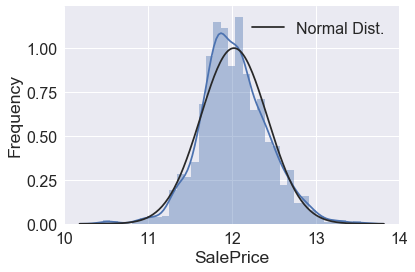

In [171]:
# Use the log1p function from numpy 
train['SalePrice'] = np.log1p(train['SalePrice'])

# Show the new plot
sns.distplot(train['SalePrice'], fit=norm)

# Get the fitted parameter used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print('Normal Distribution: mu = {:.2f} \t sigma = {:.2f}\n'.format(mu, sigma))

# Plot the normal distribution
plt.legend(['Normal Dist.'], loc='best')
plt.ylabel('Frequency')
plt.show()

**Looks much better!**

## Relationships between Features and SalePrice

As we can see from the training and testing datasets, there are too many features to successfully build a nice predicting model. Thus, we should analyze the data and extract useful features that have a real effect on SalePrice.


### Correlation Heatmap

How can we decide which one is useful and which is not among 79 features? We can't just pick several with our intuition or commen sense, and here the correlation heatmap comes:

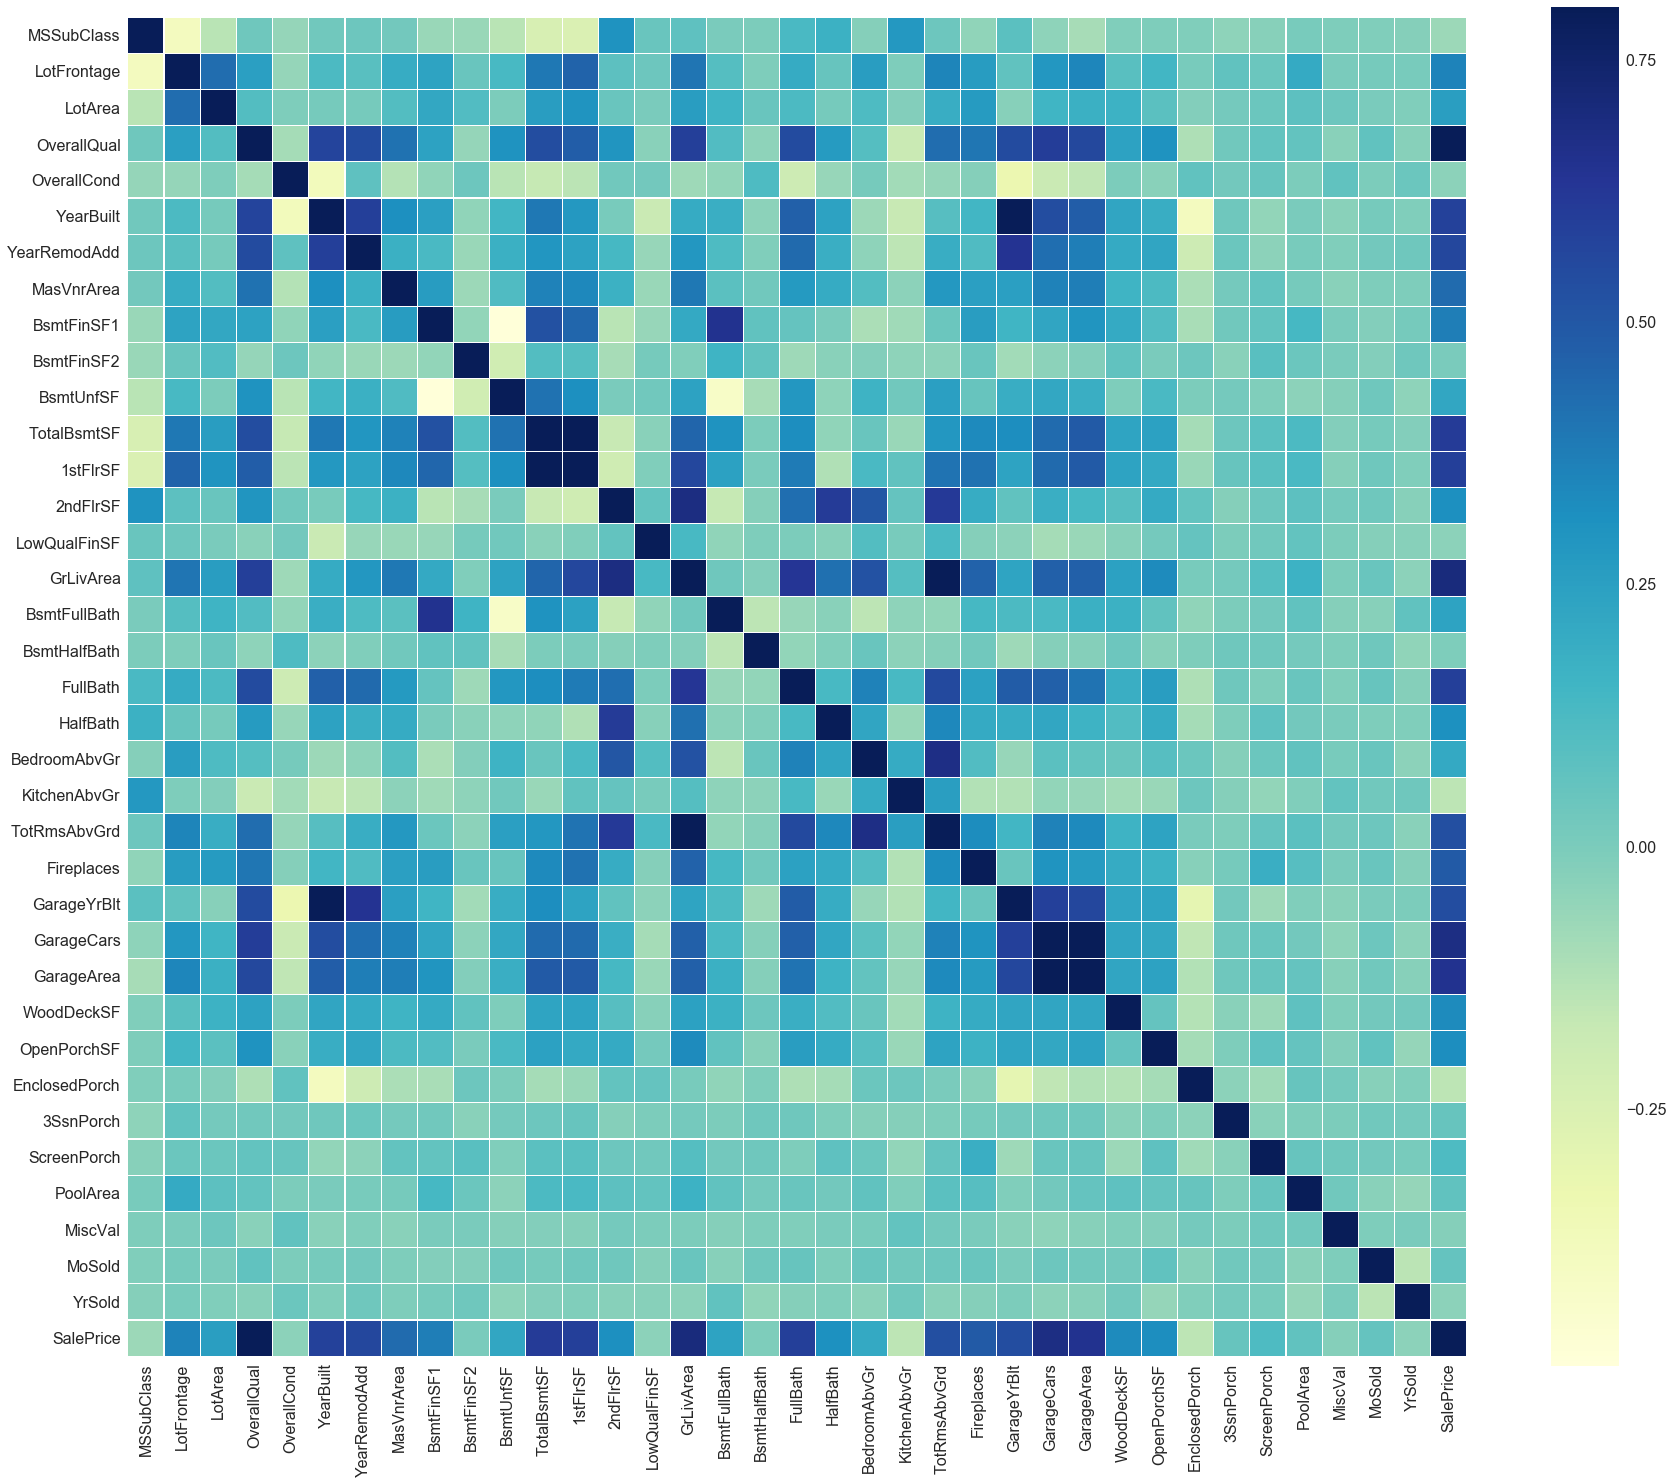

In [172]:
plt.subplots(figsize=(30, 25))
sns.heatmap(train.corr(), linewidth=0.1, linecolor='White', cmap='YlGnBu', vmax=0.8, square=True)

From the heatmap above, **the bluer the pixel block is, the stronger correlation it has to SalePrice**.

Let's list the names of those features with strong correlatoion:

* **OverallQual**: Overall material and finish quality
* **YearBuilt**: Original construction date
* **TotalBsmtSF**: Total square feet of basement area
* **1stFlrSF**: First floor square feet
* **GrLiveArea**: Above grade (ground) living area square feet
* **FullBath**: Full bathroom above grade
* **TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms)
* **GarageCars**: Size of garage in car capacity
* **GarageArea**: Size of garage in square feet

**NOTE:** 
* I picked those features according to their color, which could not be 100% accurate and scientific.
* Among those features on the list, some are redundant, such as GarageCars and GarageArea. I will analyze that later on.
* The heatmap above only works for numerical features but not for text feature such as **Neighborhood**. Therefore, the next thing I am going to do is **feature extraction and engineering**.

## Feature Engineering 

In [125]:
# Create y_train to save SalePrice from the training dataset
y_train = train['SalePrice']

**Concatenate Train and Test datasets**

In [173]:
frames = [train, test]
# Create a full dataset that contains the train and test data
full_data = pd.concat(frames)
# Drop SalePrice column from full_data
full_data.drop(['SalePrice'], axis=1, inplace=True)

# Print the first 5 rows of full_data
full_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [174]:
# Total rows and columns 
full_data.shape

(2919, 79)

### Find Missing Data

In [177]:
# Calculate the ratio of missing values for each feature
missing_data = full_data.isnull().sum() / len(full_data)
missing_data = missing_data.drop(missing_data[missing_data == 0].index).sort_values(ascending = False)
missing_df = pd.DataFrame({'Missing Ratio' :missing_data})

# Print missing_df and its shape
print(missing_df, '\n(rows, columns) = ', missing_df.shape)

              Missing Ratio
PoolQC             0.996574
MiscFeature        0.964029
Alley              0.932169
Fence              0.804385
FireplaceQu        0.486468
LotFrontage        0.166495
GarageQual         0.054471
GarageCond         0.054471
GarageFinish       0.054471
GarageYrBlt        0.054471
GarageType         0.053786
BsmtExposure       0.028092
BsmtCond           0.028092
BsmtQual           0.027749
BsmtFinType2       0.027407
BsmtFinType1       0.027064
MasVnrType         0.008222
MasVnrArea         0.007879
MSZoning           0.001370
BsmtFullBath       0.000685
BsmtHalfBath       0.000685
Utilities          0.000685
Functional         0.000685
Electrical         0.000343
BsmtUnfSF          0.000343
Exterior1st        0.000343
Exterior2nd        0.000343
TotalBsmtSF        0.000343
GarageArea         0.000343
GarageCars         0.000343
BsmtFinSF2         0.000343
BsmtFinSF1         0.000343
KitchenQual        0.000343
SaleType           0.000343 
(rows, columns) =  

**Visualize the Missing Ratio**

Text(0,0.5,'Features')

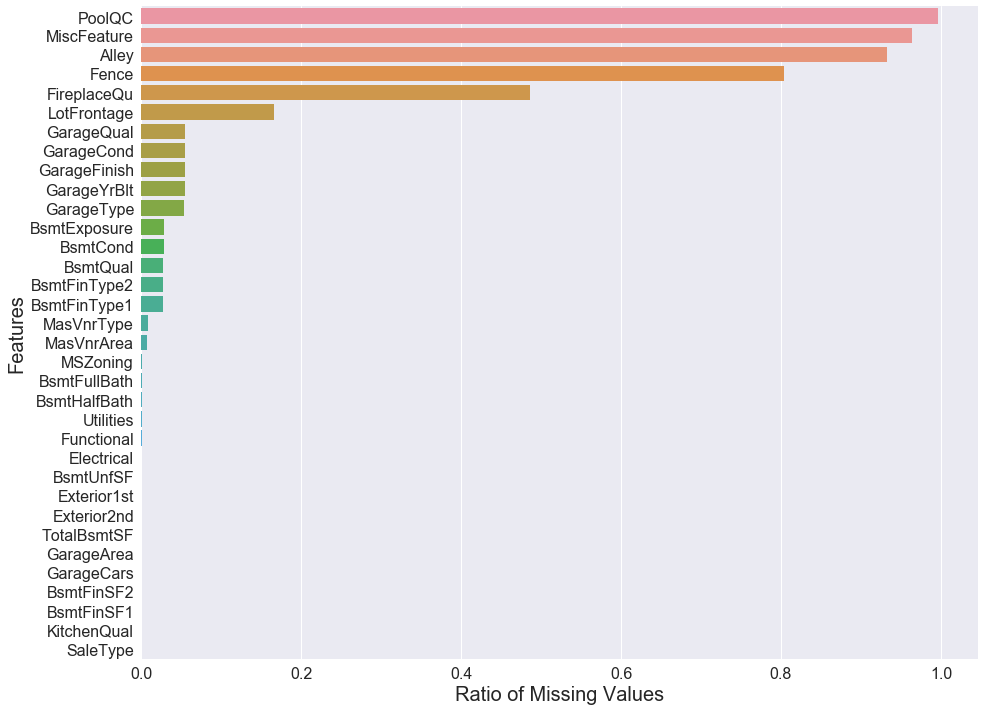

In [178]:
plt.figure(figsize = (15, 12))
sns.barplot(y=missing_data.index, x=missing_data)
plt.xlabel('Ratio of Missing Values', fontsize=20)
plt.ylabel('Features', fontsize=20)

### Impute Missing Data

* **PoolQC**: This feature stands for pool quality. `NaN` means there is no pool, and above 99% of houses do not have a pool, which makes sense.
* **MiscFeature**: Miscellaneous feature not covered in other categories. 
* **Alley**: Type of alley access.
* **Fence**: Fence quality.
* **FireplaceQu**: Fireplace quality.
* **GarageType**: Garage location.
* **GarageFinish**: Interior finish of the garage.
* **GarageQual**: Garage quality.
* **GarageCond**: Garage condition.
* **BsmtQual**: Height of the basement.
* **BsmtCond**: General condition of the basement.
* **BsmtExposure**: Walkout or garden level basement walls.
* **BsmtFinType1**: Quality of basement finished area.
* **BsmtFinType2**: Quality of second finished area (if present).
* **MasVnrArea**: Masonry veneer area in square feet.
* **MSSubClass**: The building class.

Replace missing values of above features with `None`.

In [179]:
features = ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrArea', 'MSSubClass')
for feature in features:
    full_data[feature] = full_data[feature].fillna("None")
    #for dataset in frames:
        #dataset[feature] = dataset[feature].fillna('None')

* **LotFrontage**: Linear feet of street connected to property. We can replace the missing values with the **median LotFrontage of the neighborhood**.

In [180]:
#for dataset in frames:
    #dataset['LotFrontage'] = dataset.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
full_data['LotFrontage'] = full_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

* **GarageYrBlt**: Year garage was built. We can replace the missing values with the **median GarageYrBlt of the neighborhood**.

In [181]:
#for dataset in frames:
 #   dataset['GarageYrBlt'] = dataset.groupby('Neighborhood')['GarageYrBlt'].transform(lambda x: x.fillna(x.mode()))
#full_data['GarageYrBlt'] = full_data.groupby('Neighborhood')['GarageYrBlt'].transform(lambda x: x.fillna(x.median()))

* **GarageArea**: Size of garage in square feet.
* **GarageCars**: Size of garage in car capacity.
* **BsmtFinSF1**: Type 1 finished square feet.
* **BsmtFinSF2**: Type 2 finished square feet.
* **BsmtUnfSF**: Unfinished square feet of basement area.
* **TotalBsmtSF**: Total square feet of basement area.
* **BsmtFullBath**: Basement full bathroom.
* **BsmtHalfBath**: Basement half bathroom.
* **MasVnrType**: Masonry veneer type.

Replace the missing values of above features with `0`.

In [182]:
features = ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
            'BsmtHalfBath', 'MasVnrType')
for feature in features:
    full_data[feature] = full_data[feature].fillna(0)
    #for dataset in frames:
       # dataset[feature] = dataset[feature].fillna(0)

* **MSZoning**: The general zoning classification.
* **Electrical**: Electrical system.
* **KitchenQual**: Kitchen quality.
* **Exterior1st**: Exterior covering on house.
* **Exterior2nd**: Exterior covering on house (if more than one material).
* **SaleType**: Type of sale.

Replace the missing values of above feature with their mode.

In [183]:
features = ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType')

for feature in features:
    full_data[feature] = full_data[feature].fillna(full_data[feature].mode()[0])
   # for dataset in frames:
    #    dataset[feature] = dataset[feature].fillna(dataset[feature].mode()[0])

* **Functional**: Home functionality rating. `NaN` means typical, so replace the missing values with `Typ`.

In [184]:
#for dataset in frames:
 #   dataset['Functional'] = dataset['Functional'].fillna('Typ')
full_data['Functional'] = full_data['Functional'].fillna('Typ')

**Check if there is any missing value remained.**

In [185]:
# Print missing values in train dataset
missing_data = full_data.isnull().sum() / len(full_data)
missing_data = missing_data.drop(missing_data[missing_data == 0].index).sort_values(ascending = False)
print(missing_data)

Utilities    0.000685
dtype: float64


The only feature with missing values is **Utilities** in the testing data.

**Let's see how many kinds of Utilities we have in the train data.**

In [186]:
full_data['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

For this categoric feature, all we have in our both training and testing data is `AllPub` expect for **one** `NoSeWa`. Thus, we can conclude this feature **won't help in our predicting model**.

### Remove Utilities

In [187]:
#for dataset in frames:
 #   dataset = dataset.drop(['Utilities'], axis=1, inplace=True)
full_data = full_data.drop(['Utilities'], axis=1)

No more missing values!

In [188]:
full_data['MSSubClass'] = full_data['MSSubClass'].apply(str)

# Convert OverallCond, YrSold, and MoSold into categoric features
for i in ['OverallCond', 'YrSold', 'MoSold']:
    full_data[i] = full_data[i].astype(str)

### Label Encoding

**Use `LabelEncoder` to split values of each feature into different categories.**

In [189]:
from sklearn.preprocessing import LabelEncoder

features = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond', 'HeatingQC',
            'PoolQC', 'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish',
            'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 
            'OverallCond', 'YrSold', 'MoSold')

# Apply LabelEncoder to each feature
for feature in features:
   # for dataset in frames:
    le = LabelEncoder()
    le.fit(list(full_data[feature].values))
    full_data[feature] = le.transform(list(full_data[feature].values))
        
# Print the first five rows of the training data
full_data.head(10)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,1,3,1Fam,4,3,706.0,0.0,...,Normal,WD,0,1,8,856.0,0,2003,2003,2
1,1262,0,0,1,3,1Fam,4,1,978.0,0.0,...,Normal,WD,0,1,6,1262.0,298,1976,1976,1
2,920,866,0,1,3,1Fam,4,2,486.0,0.0,...,Normal,WD,0,1,6,920.0,0,2001,2002,2
3,961,756,0,1,3,1Fam,1,3,216.0,0.0,...,Abnorml,WD,0,1,7,756.0,0,1915,1970,0
4,1145,1053,0,1,4,1Fam,4,0,655.0,0.0,...,Normal,WD,0,1,9,1145.0,192,2000,2000,2
5,796,566,320,1,1,1Fam,4,3,732.0,0.0,...,Normal,WD,0,1,5,796.0,40,1993,1995,3
6,1694,0,0,1,3,1Fam,4,0,1369.0,0.0,...,Normal,WD,0,1,7,1686.0,255,2004,2005,1
7,1107,983,0,1,3,1Fam,4,2,859.0,32.0,...,Normal,WD,0,1,7,1107.0,235,1973,1973,3
8,1022,752,0,1,2,1Fam,4,3,0.0,0.0,...,Abnorml,WD,0,1,8,952.0,90,1931,1950,2
9,1077,0,0,1,2,2fmCon,4,3,851.0,0.0,...,Normal,WD,0,1,5,991.0,0,1939,1950,2


### Add new feature called `TotalSF`

In [190]:
#for dataset in frames:
 #   dataset['TotalSF'] = dataset['TotalBsmtSF'] + dataset['1stFlrSF'] + dataset['2ndFlrSF']
full_data['TotalSF'] = full_data['TotalBsmtSF'] + full_data['1stFlrSF'] + full_data['2ndFlrSF']

### Skewed Features

In [191]:
numeric_features = full_data.dtypes[full_data.dtypes != "object"].index

skewed_features = full_data[numeric_features].apply(lambda x: x.skew()).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewness': skewed_features})
print(skewness)

                Skewness
MiscVal        21.958480
PoolArea       16.907017
LotArea        12.829025
LowQualFinSF   12.094977
3SsnPorch      11.381914
LandSlope       4.977715
KitchenAbvGr    4.304467
BsmtFinSF2      4.148275
EnclosedPorch   4.005950
ScreenPorch     3.948723
BsmtHalfBath    3.933616
OpenPorchSF     2.536417
WoodDeckSF      1.843380
TotalSF         1.512256
LotFrontage     1.506478
1stFlrSF        1.470360
BsmtFinSF1      1.425963
GrLivArea       1.270010
TotalBsmtSF     1.157489
BsmtUnfSF       0.919812
2ndFlrSF        0.862118
TotRmsAbvGrd    0.758757
Fireplaces      0.733872
HalfBath        0.694924
BsmtFullBath    0.625153
OverallCond     0.570605
HeatingQC       0.486906
FireplaceQu     0.333959
BedroomAbvGr    0.326492
GarageArea      0.239380
OverallQual     0.197212
FullBath        0.167692
MSSubClass      0.138467
YrSold          0.132467
BsmtFinType1    0.084676
GarageCars     -0.219694
YearRemodAdd   -0.451252
BsmtQual       -0.488524
YearBuilt      -0.600114


### Box Cos Transformation of Highly Skewed Features

A Box Cox transformation is a method to transform non-normal **dependent variables** into a normally distributed shape. Here is the formula:
$$
\begin{aligned}
Y(x) = \frac{(Z(x)^\lambda - 1)}{\lambda}
\end{aligned}
$$

Previously, I've used **Log transformation** for SalePrice feature. And it actually is a special case of Box Cox transformation when $\lambda$ = 0.

In [192]:
# Pick those highly skewed features
skewness = skewness[abs(skewness) > 0.75]
skewness.shape

(58, 1)

There are 58 highly skewed numeric features.

In [193]:
from scipy.special import boxcox1p

skewed_features = skewness.index
#for dataset in frames:
for feature in skewed_features:
    # Set lambda to be 0.15
    full_data[feature] = boxcox1p(full_data[feature], 0.15)
    full_data[feature] += 1

### Create Dummy Variables

In [194]:
#for dataset in frames:
 #   dataset = pd.get_dummies(dataset)
 #   print(dataset.head())
full_data = pd.get_dummies(full_data)

In [195]:
full_data.shape

(2919, 666)

Get the new Train and Test datasets

In [196]:
# Length of the training data
train_len = train.shape[0]
train = full_data[:train_len]
test = full_data[train_len:]

## Modeling

In [212]:
# Import modules
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

Import **XGBoost**

In [207]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xgb

### k-Fold Cross-Validation

**Cross-validation** is a resampling procedure used to evaluate ML models on a limited data sample.

The genereal procedure is as follows:
* Shuffle the dataset randomly.
* Split the dataset into k groups.
* For each single group, take it as a testing dataset and the remaining groups as a training set, then fit a model on the training set and evaluate it on the testing one, nad finally retain the evaluation score and discard the model.
* Summarize the skill of the model using the sample of model evaluation scores.

Thus, I am going to use [**cross_val_score**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) from Sklearn.

In [198]:
# Number of groups
k_folds = 5

def cv_evaluation(model):
    kf = KFold(k_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    score = np.sqrt(-cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error', cv=kf))
    return (score)

### Base Models

* **LASSO Regression**:

In [224]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0008, random_state=1))

# Print out the score
score = cv_evaluation(lasso)
print('LASSO Score: {:.4f}'.format(score.mean()))

LASSO Score: 0.1243


* **Elastic Net Regression**:

In [200]:
enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0008, random_state=1, l1_ratio=0.9))

# Print out the score
score = cv_evaluation(enet)
print('Elsatic Net Score: {:.4f}'.format(score.mean()))

Elsatic Net Score: 0.1241


* **Kernel Ridge Regression**:

In [210]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

# Print out the score
score = cv_evaluation(KRR)
print('Kernel Ridge Score: {:.4f}'.format(score.mean()))

Kernel Ridge Score: 0.1288


* **Gradient Boosting Regression**:

In [211]:
gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=5)

# Print out the score
score = cv_evaluation(gboost)
print('Gradient Boosting Score: {:.4f}'.format(score.mean()))

Gradient Boosting Score: 0.1236


* **XGBoost**: 

Honestly, I don't really know how XGBoost works, I just played around with the parameters ;)

In [216]:
xgb_model = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, learning_rate=0.01, max_depth=4,
                             min_child_weight=1.5, n_estimators=7200, reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2, silent=1, random_state=7, nthread=-1)

score = cv_evaluation(xgb_model)
print('XGBoost Score: {:.4f}'.format(score.mean()))

XGBoost Score: 0.1204


* **LightGBM**:

In [217]:
lgb_model = lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05, n_estimators=720, max_bin=55,
                              bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.2319, feature_fraction_seed=9, 
                              bagging_seed=9, min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

score = cv_evaluation(lgb_model)
print('LightGBM score: {:.4f}'.format(score.mean()))

LightGBM score: 0.1223


### Define a rmsle evaluation function

In [218]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### XGBoost

In [219]:
xgb_model.fit(train, y_train)
xgb_train_pred = xgb_model.predict(train)
xgb_pred = np.expm1(xgb_model.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.0740889840741358


In [221]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = xgb_pred
sub.to_csv('submission.csv', index=False)

## To be continued...